# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import savgol_filter

def magnitude(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

# Read data

In [4]:
# Read the CSV file
df = pd.read_csv(
    "/home/m3rc7pi/workspace/arc/log/run/20240407/1.csv", 
    header=None, 
    names=["timestamp", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"],
    skiprows=0,
)

In [5]:
acc_x_offset = df['acc_x'][0]
acc_y_offset = df['acc_y'][0]
acc_z_offset = df['acc_z'][0]
gyro_x_offset = df['gyro_x'][0]
gyro_y_offset = df['gyro_y'][0]
gyro_z_offset = df['gyro_z'][0]

print(f"Acc Offset: {acc_x_offset}, {acc_y_offset}, {acc_z_offset}")
print(f"Gyro Offset: {gyro_x_offset}, {gyro_y_offset}, {gyro_z_offset}")

acc_x_scale = df['acc_x'][1]
acc_y_scale = df['acc_y'][1]
acc_z_scale = df['acc_z'][1]
gyro_x_scale = df['gyro_x'][1]
gyro_y_scale = df['gyro_y'][1]
gyro_z_scale = df['gyro_z'][1]

print(f"Acc Scale: {acc_x_scale}, {acc_y_scale}, {acc_z_scale}")
print(f"Gyro Scale: {gyro_x_scale}, {gyro_y_scale}, {gyro_z_scale}")

df=df.iloc[2:]

Acc Offset: -4603.0, -928.0, 1047.0
Gyro Offset: 334.0, 21.0, -7.0
Acc Scale: -4603.0, -928.0, 1047.0
Gyro Scale: -1.0, 2.0, 3.0


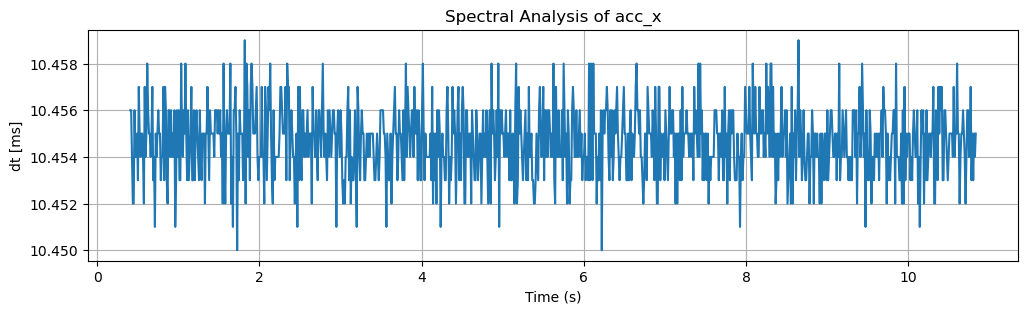

count    998.000000
mean      10.454651
std        0.001503
min       10.450000
25%       10.454000
50%       10.455000
75%       10.456000
max       10.459000
Name: delta_time, dtype: float64

Average sampling frequency: 95.65120548313348 [Hz]


In [6]:
df['timestamp'] = df['timestamp'] / 1e6
df["delta_time"] = df['timestamp'].diff() * 1000
Fs = 1 / (df["delta_time"][2:].mean()/1000)  # Sampling frequency (Hz)

plt.figure(figsize=(12, 3))
plt.plot(df['timestamp'][2:], df["delta_time"][2:])  # Plot only positive frequencies
plt.xlabel('Time (s)')
plt.ylabel('dt [ms]')
plt.title('Spectral Analysis of acc_x')
plt.grid(True)
plt.show()

print(df["delta_time"][2:].describe())
print("\nAverage sampling frequency:", Fs, "[Hz]")

# Accelerometer

In [7]:
def plot_acc(x:str, y:str, z:str, figsize=(12, 6)):
    fig, axs = plt.subplots(2, 1, figsize=figsize)
    axs[0].plot(df['timestamp'], df[x], label=x)
    axs[0].plot(df['timestamp'], df[y], label=y)
    axs[0].plot(df['timestamp'], df[z], label=z)
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Acceleration [m/s]')
    axs[0].set_title('Accelerometer Data')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(df['timestamp'], magnitude(df[x],df[y], df[z]), label="magniude")
    axs[1].set_xlabel('Time [s]')
    axs[1].set_title('Magnitude')
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()

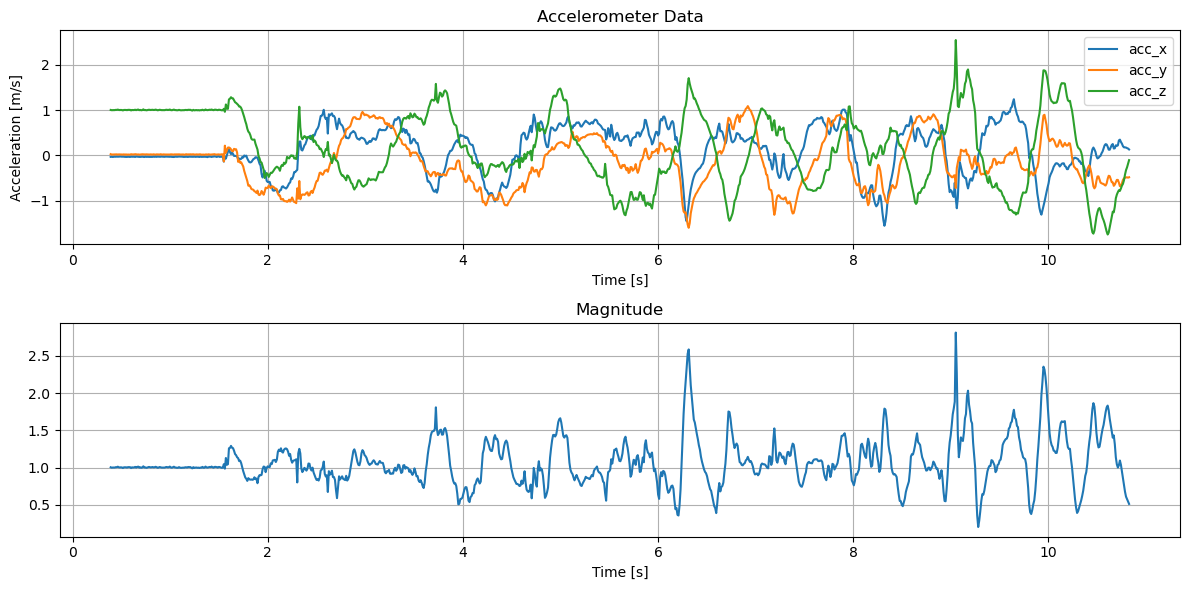

             acc_x        acc_y        acc_z  acc_magnitude
count  1000.000000  1000.000000  1000.000000    1000.000000
mean      0.120479    -0.138147     0.176347       1.074848
std       0.518220     0.544049     0.792659       0.318053
min      -1.554690    -1.599120    -1.746830       0.201491
25%      -0.162964    -0.542419    -0.417358       0.900146
50%       0.185791    -0.107178     0.159546       1.009285
75%       0.525879     0.180481     0.962952       1.221828
max       1.239750     1.087650     2.545900       2.813788


In [8]:
df['acc_magnitude'] = magnitude(df['acc_x'], df['acc_y'], df['acc_z'])

plot_acc('acc_x', 'acc_y', 'acc_z')
print(df[["acc_x", "acc_y", "acc_z", 'acc_magnitude']].describe())

In [9]:
def process_data(axis, window_length=51, polyorder=3):
    df[axis + '_filtered'] = savgol_filter(df[axis], window_length=window_length, polyorder=polyorder)

    # Compute the difference between acc_x and acc_x_filtered
    df[axis + '_noise'] = df[axis] - df[axis + '_filtered']

    # Perform FFT on acc_x
    df[axis + '_fft'] = np.fft.fft(df[axis])
    df[axis + '_freq']  = np.fft.fftfreq(len(df[axis]), d=1/Fs)  # Frequency bins

    # Perform FFT on acc_x_filtered
    df[axis + '_filtered_fft'] = np.fft.fft(df[axis + '_filtered'])
    df[axis + '_filtered_freq'] = np.fft.fftfreq(len(df[axis + '_filtered']), d=1/Fs)  # Frequency bins

def plot_data_filtered(axis, y_label, figsize=(12, 8)):
    fig, axs = plt.subplots(4, 1, figsize=figsize)

    axs[0].plot(df['timestamp'], df[axis], label=axis)
    axs[0].plot(df['timestamp'], df[axis + '_filtered'], label=axis + '_filtered')
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel(y_label)
    axs[0].set_title('Filtered ' + axis)
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(df['timestamp'], df[axis + '_noise'], label=axis + '_noise')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylabel(y_label)
    axs[1].set_title('Noise of '+ axis)
    axs[1].set_ylim(-0.5, 0.5)
    axs[1].legend()
    axs[1].grid()

    dim = len(df[axis + '_freq'])//2
    axs[2].plot(df[axis + '_freq'][0:dim], np.abs(df[axis + '_fft'][0:dim]))  # Plot only positive frequencies
    axs[2].set_xlabel('Frequency [Hz]')
    axs[2].set_ylabel('Amplitude')
    axs[2].set_title('Spectrum of ' + axis)
    axs[2].grid()

    filt_dim = len(df[axis + '_filtered_freq'])//2
    axs[3].plot(df[axis + '_filtered_freq'][0:filt_dim], np.abs(df[axis + '_filtered_fft'][0:filt_dim]))
    axs[3].set_xlabel('Frequency [Hz]')
    axs[3].set_ylabel('Amplitude')
    axs[3].set_title('Spectrum of ' + axis + 'Filtered')
    axs[3].grid()

    plt.tight_layout()
    plt.show()

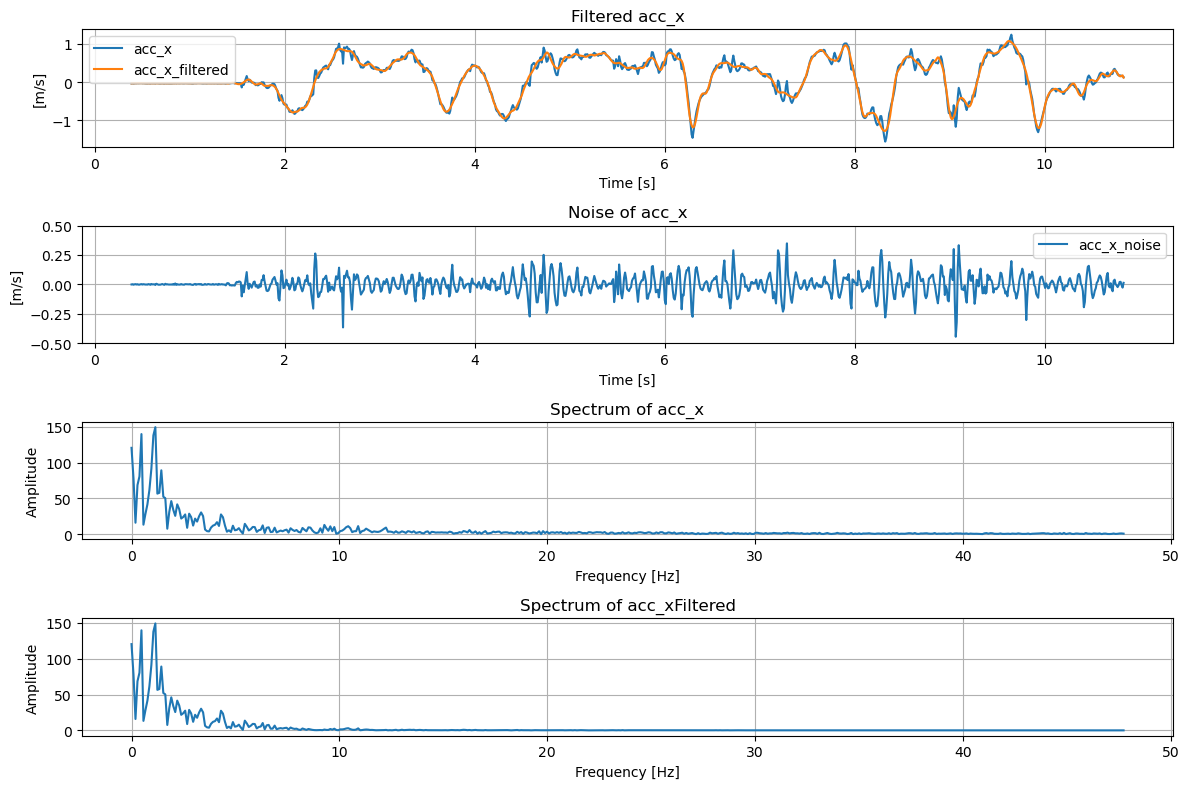

             acc_x  acc_x_filtered  acc_x_noise
count  1000.000000     1000.000000  1000.000000
mean      0.120479        0.120429     0.000050
std       0.518220        0.511755     0.082058
min      -1.554690       -1.275343    -0.444995
25%      -0.162964       -0.176179    -0.040094
50%       0.185791        0.188527     0.000609
75%       0.525879        0.521481     0.040958
max       1.239750        1.074142     0.348905


In [18]:
process_data('acc_x', window_length=41, polyorder=9)
plot_data_filtered('acc_x', y_label='[m/s]')

print(df[["acc_x", "acc_x_filtered", "acc_x_noise"]].describe())

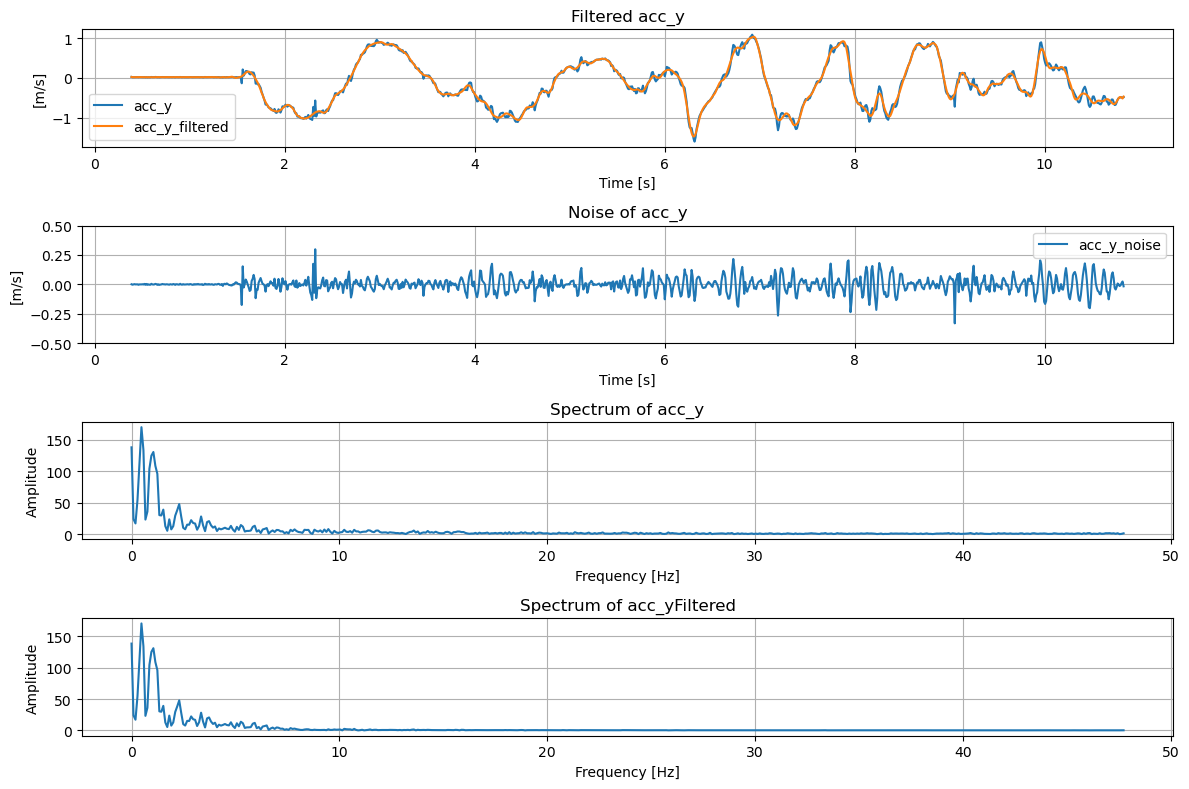

             acc_y  acc_y_filtered  acc_y_noise
count  1000.000000     1000.000000  1000.000000
mean     -0.138147       -0.138103    -0.000043
std       0.544049        0.540082     0.062528
min      -1.599120       -1.472323    -0.331081
25%      -0.542419       -0.540719    -0.029076
50%      -0.107178       -0.099435     0.000376
75%       0.180481        0.184733     0.028990
max       1.087650        1.034977     0.298557


In [19]:
process_data('acc_y', window_length=41, polyorder=9)
plot_data_filtered('acc_y', y_label='[m/s]')

print(df[["acc_y", "acc_y_filtered", "acc_y_noise"]].describe())

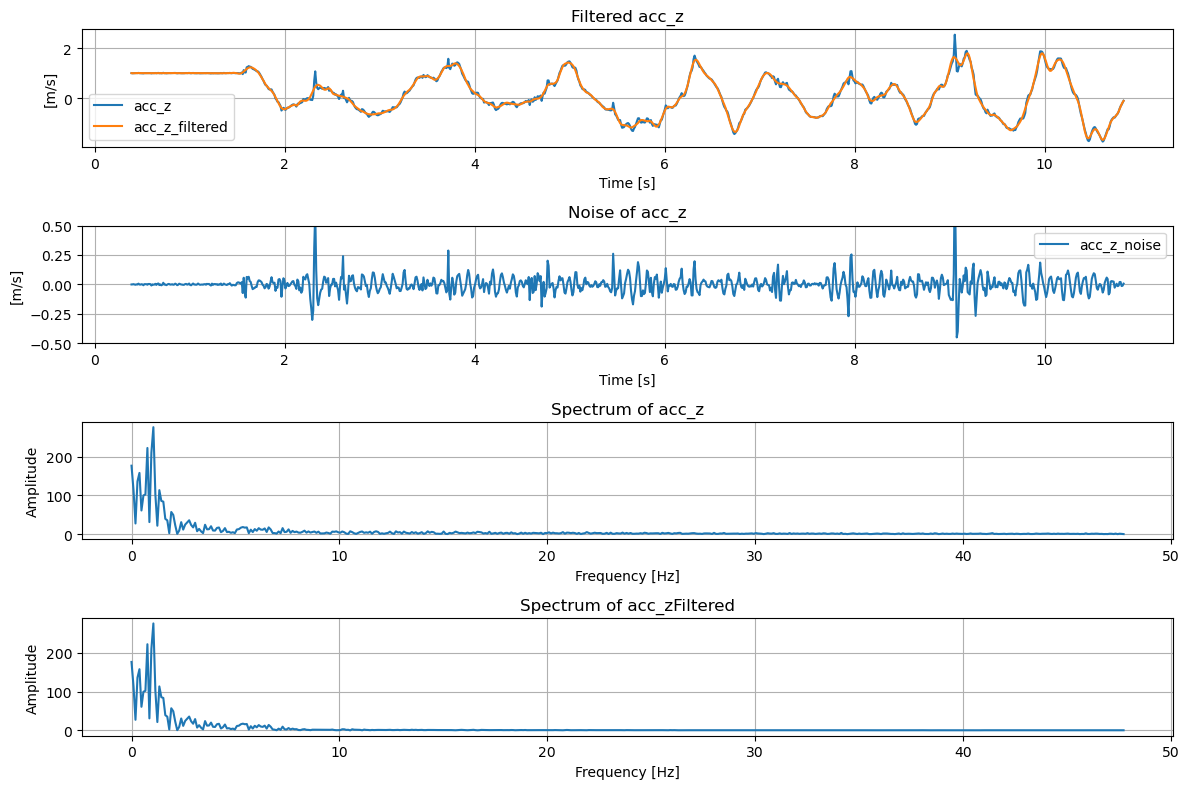

             acc_z  acc_z_filtered  acc_z_noise
count  1000.000000     1000.000000  1000.000000
mean      0.176347        0.176390    -0.000043
std       0.792659        0.788095     0.075932
min      -1.746830       -1.677412    -0.450539
25%      -0.417358       -0.411046    -0.033339
50%       0.159546        0.149151    -0.000914
75%       0.962952        0.942188     0.029494
max       2.545900        1.800624     0.913384


In [20]:
process_data('acc_z', window_length=41, polyorder=9)
plot_data_filtered('acc_z', y_label='[m/s]')

print(df[["acc_z", "acc_z_filtered", "acc_z_noise"]].describe())

# Gyroscope

In [21]:
def plot_gyro(x:str, y:str, z:str, figsize=(12, 3)):
    plt.figure(figsize=figsize)
    plt.plot(df['timestamp'], df[x], label=x)
    plt.plot(df['timestamp'], df[y], label=y)
    plt.plot(df['timestamp'], df[z], label=z)
    plt.xlabel('Timestamp [s]')
    plt.ylabel('Angular Velocity [rad/s]')
    plt.title('Gyroscope Data')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

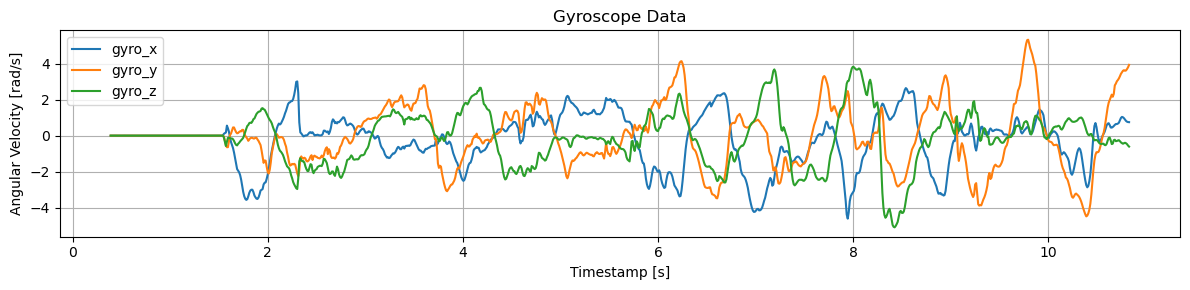

             acc_x        acc_y        acc_z  acc_magnitude
count  1000.000000  1000.000000  1000.000000    1000.000000
mean      0.120479    -0.138147     0.176347       1.074848
std       0.518220     0.544049     0.792659       0.318053
min      -1.554690    -1.599120    -1.746830       0.201491
25%      -0.162964    -0.542419    -0.417358       0.900146
50%       0.185791    -0.107178     0.159546       1.009285
75%       0.525879     0.180481     0.962952       1.221828
max       1.239750     1.087650     2.545900       2.813788


In [22]:
plot_gyro("gyro_x", "gyro_y", "gyro_z")
print(df[["acc_x", "acc_y", "acc_z", 'acc_magnitude']].describe())

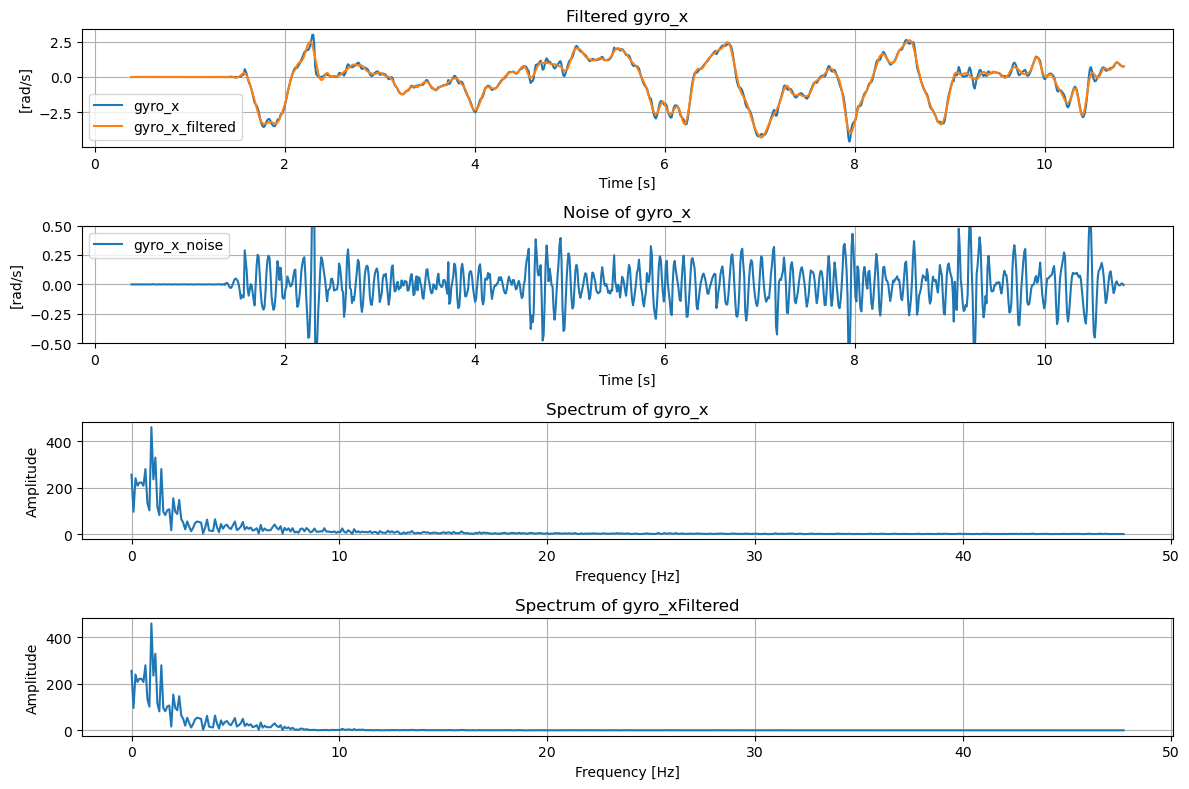

            gyro_x  gyro_x_filtered  gyro_x_noise
count  1000.000000      1000.000000   1000.000000
mean     -0.255929        -0.256049      0.000120
std       1.421116         1.408738      0.158589
min      -4.602050        -4.306554     -0.765838
25%      -0.939636        -0.934051     -0.081599
50%      -0.001953        -0.002283      0.000240
75%       0.639343         0.589714      0.084451
max       3.007810         2.613043      1.001411


In [26]:
process_data('gyro_x', window_length=41, polyorder=9)
plot_data_filtered('gyro_x', y_label='[rad/s]')

print(df[["gyro_x", "gyro_x_filtered", "gyro_x_noise"]].describe())

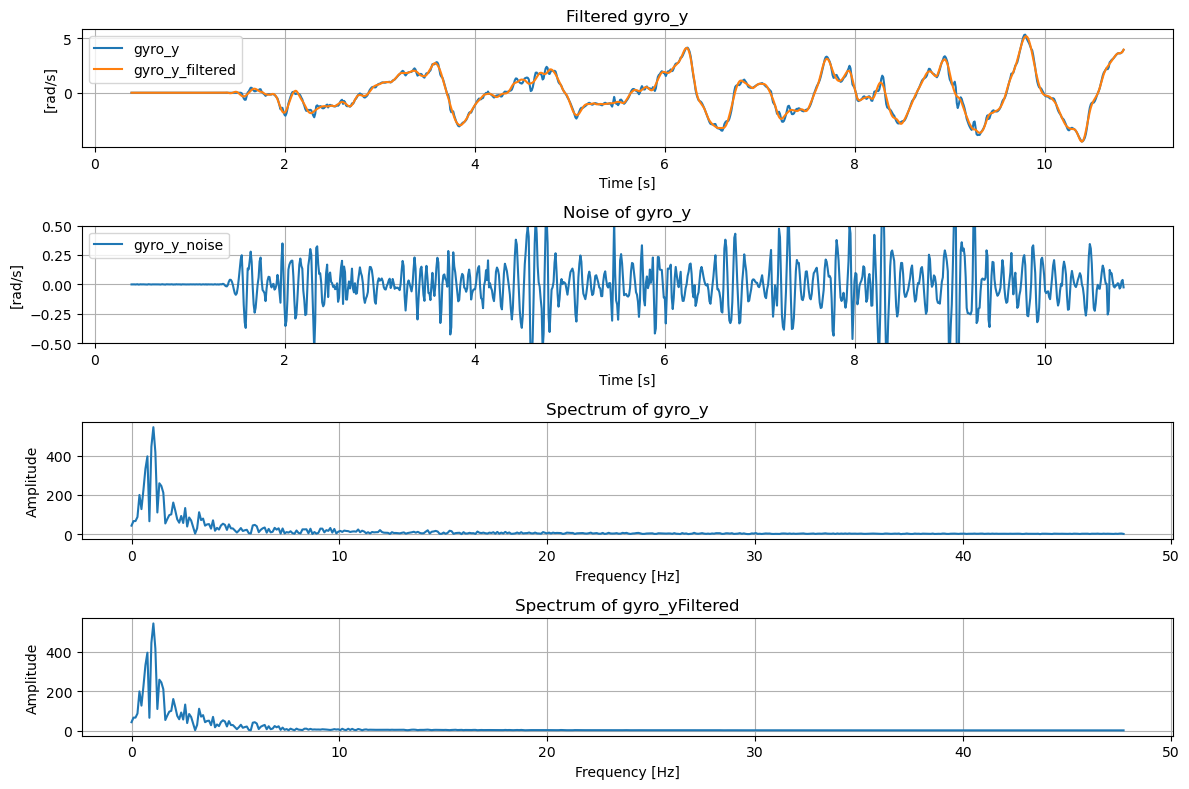

            gyro_y  gyro_y_filtered  gyro_y_noise
count  1000.000000      1000.000000   1000.000000
mean     -0.043501        -0.043557      0.000055
std       1.708772         1.697396      0.184677
min      -4.476320        -4.476764     -1.012620
25%      -1.147155        -1.106054     -0.092512
50%       0.000488         0.000696      0.000139
75%       0.987182         0.975662      0.094876
max       5.321040         5.185168      0.988600


In [27]:
process_data('gyro_y',window_length=41, polyorder=9)
plot_data_filtered('gyro_y', y_label='[rad/s]')

print(df[["gyro_y", "gyro_y_filtered", "gyro_y_noise"]].describe())

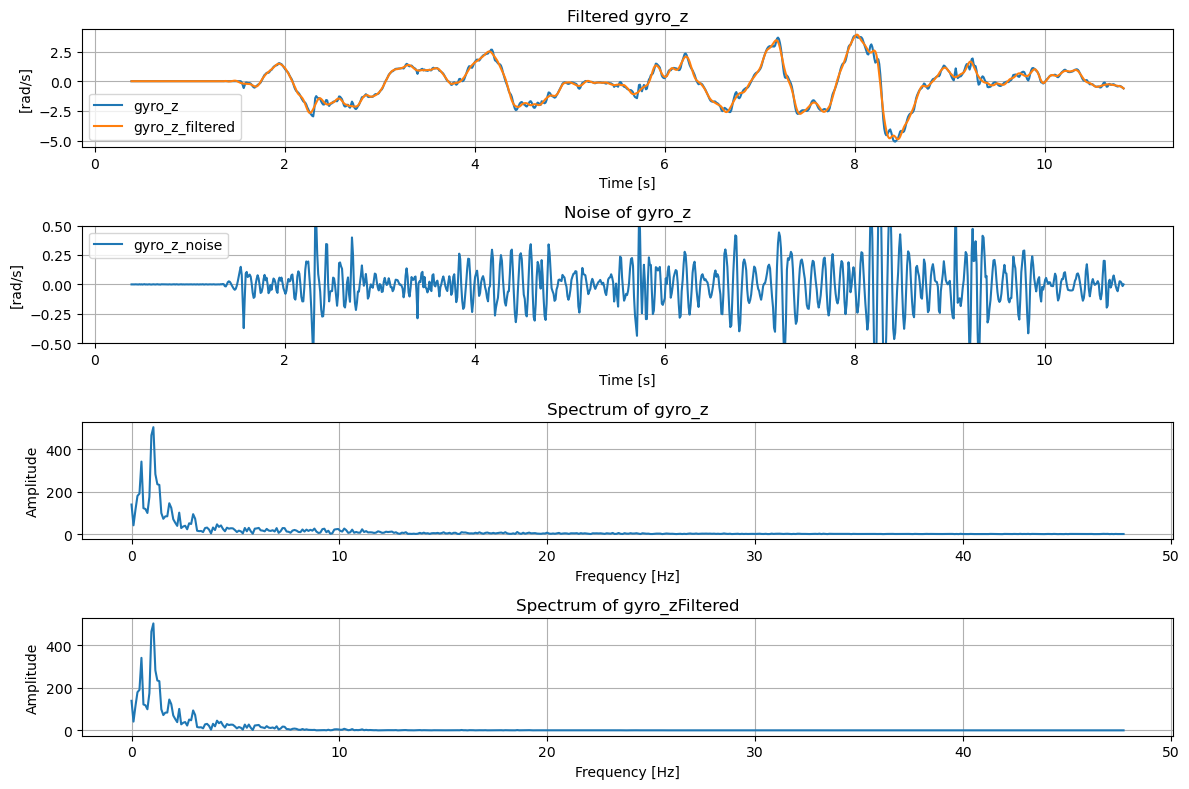

            gyro_z  gyro_z_filtered  gyro_z_noise
count  1000.000000      1000.000000   1000.000000
mean     -0.139419        -0.139415     -0.000004
std       1.468042         1.456372      0.177256
min      -5.083500        -4.884956     -0.936241
25%      -0.914184        -0.984022     -0.074918
50%       0.000244        -0.002221      0.000396
75%       0.782165         0.773426      0.077930
max       3.819340         3.917183      0.892766


In [28]:
process_data('gyro_z', window_length=41, polyorder=9)
plot_data_filtered('gyro_z', y_label='[rad/s]')

print(df[["gyro_z", "gyro_z_filtered", "gyro_z_noise"]].describe())